# Machine Learning: Exercise 2

## 1 Data Preperation

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import multivariate_normal as gaussian
# k-fold instance for cross validation
kf = KFold(n_splits=10, shuffle=True)

In [2]:
# load data
digits = load_digits()
print(f"Dataset size: {len(digits.data)}")

# filter for digits 1 and 7
mask = (digits.target == 1) | (digits.target == 7)
x_data = digits.data[mask]
y_labels = digits.target[mask]
print(f"Filtered dataset size (only label 1 & 7): {len(x_data)}")
mask1 = y_labels == 1
mask7 = y_labels == 7

Dataset size: 1797
Filtered dataset size (only label 1 & 7): 361


## 1.1 Dimension Reduction
To reduce to feature dimenension of the images, we take the average for every pixel per class ("1" & "7"), compare them and find the two pixels with the largest difference and use them as new features.

In [3]:
diff = abs(np.mean(x_data[mask1], axis=0)-np.mean(x_data[mask7], axis=0))
feature_pixels = diff.argsort()[-2:]
# function for data reduction to 2 features
reduce_dim = lambda x, pixels : x[:,pixels]
print(f"Used pixels as features: {feature_pixels[0]} & {feature_pixels[1]}")

# reduce all feature data
x_features = reduce_dim(x_data, feature_pixels)

Used pixels as features: 60 & 19


## 1.2 Scatterplot

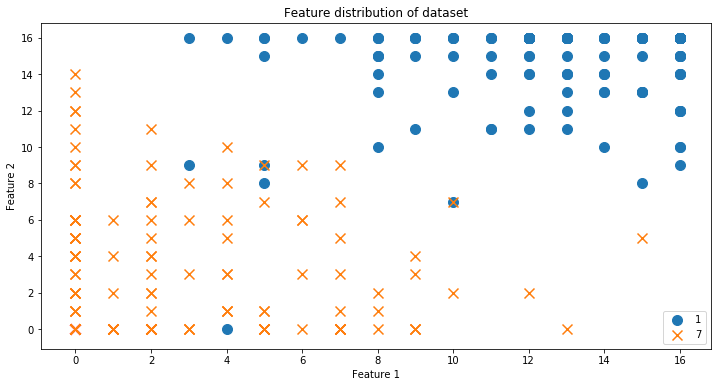

In [4]:
# plot features of data and label with marker/color
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(x_features[mask1,0], x_features[mask1,1], marker='o', label='1', s=100)
ax.scatter(x_features[mask7,0], x_features[mask7,1], marker='x', label='7', s=100)
ax.set_title("Feature distribution of dataset")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(loc='lower right');

Note: We don't create a training/test dataset, because for plotting we use all the data for training, and apply crossvalidation later.

# 2 Nearest Mean
## 2.1 Implementation

We use a class for the implementation of the nearest mean classifier, because we don't need to calculate the means for every classification, only once while training. (There is however a function as required in the assignment)

In [5]:
class NearestMeanClass:
    "Class for nearest mean classifier, calculates mean on initialization"
    def __init__(self, x_train, y_train):
        # find possible labels
        self.label_names = np.unique(y_train)
        # feature dimension
        self.feature_size = x_train.shape[1]
        # calculate means for all labels
        self.means = np.empty((len(self.label_names), self.feature_size))
        for i, label in enumerate(self.label_names):
            self.means[i] = np.mean(x_train[y_train == label], axis=0)
    
    def test_single(self, x_test):
        "Classify single sample"
        # minimize euclidean distance to all means
        label_index = np.argmin(np.sum(np.square(x_test-self.means), axis=1))
        return self.label_names[label_index]
    
    def test_set(self, x_test):
        "Classify test dataset"
        labels = np.fromiter((self.test_single(x) for x in x_test),
                             self.label_names.dtype)
        return labels
def nearest_mean(training_features, training_labels, test_features):
    "Function as required in assignment, uses NearestMeanClass"
    nm = NearestMeanClass(training_features, training_labels)
    return nm.test_set(test_features)

## 2.2 Visualization

In [6]:
# train NM model for plotting
nm = NearestMeanClass(x_features, y_labels)

In [7]:
# create grid in feature space
x = np.linspace(-0.5, 16.5, 200)
y = np.linspace(-0.5, 16.5, 200)
xv, yv = np.meshgrid(x, y)
grid = np.column_stack([xv.reshape(40000), yv.reshape(40000)])
# classify grid using nearest mean
prediction = nm.test_set(grid).reshape(200,200)

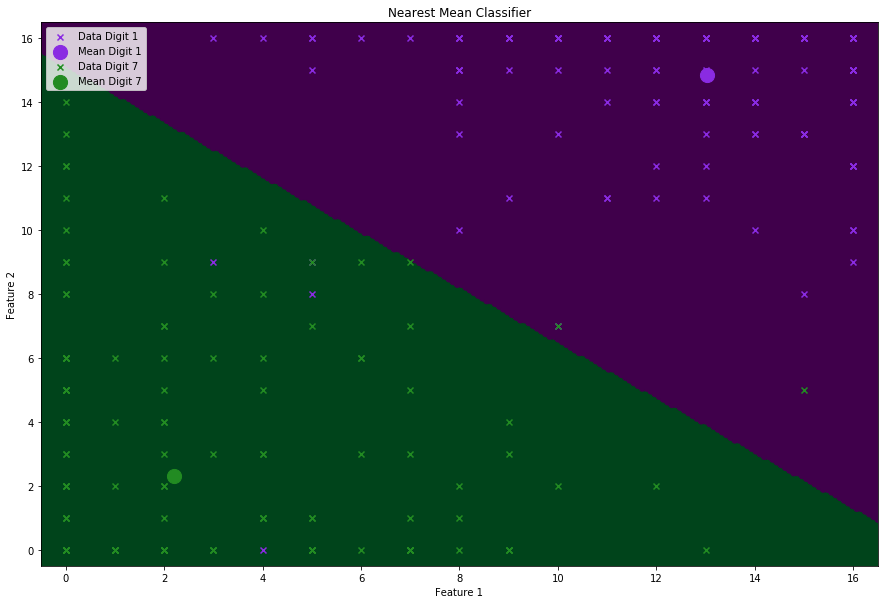

In [8]:
# plotting of 
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.axis([-0.5,16.5,-0.5,16.5])
ax.scatter(xv, yv, c=prediction, cmap='PRGn')
ax.scatter(x_features[mask1,0], x_features[mask1,1], marker='x',
           label='Data Digit 1', color='blueviolet')
ax.scatter(nm.means[0,0], nm.means[0,1], marker='o',
           label='Mean Digit 1', color='blueviolet', s=200)
ax.scatter(x_features[mask7,0], x_features[mask7,1], marker='x',
           label='Data Digit 7', color='forestgreen')
ax.scatter(nm.means[1,0], nm.means[1,1], marker='o',
           label='Mean Digit 7', color='forestgreen', s=200)
ax.set_title("Nearest Mean Classifier")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend();

## 2.3 Performance evaluation

In [9]:
# Calculate performance using 10-fold cross validation
errors_nm = []
errors_train_nm = []
for train, test in kf.split(x_features, y_labels):
    nm = NearestMeanClass(x_features[train], y_labels[train])
    # calculate error on test data
    pred_test = nm.test_set(x_features[test])
    compare_test = pred_test == y_labels[test]
    errors_nm.append(1 - np.sum(compare_test) / len(compare_test))
    
    # calculate error on training data
    pred_train = nm.test_set(x_features[train])
    compare_train = pred_train == y_labels[train]
    errors_train_nm.append(1 - np.sum(compare_train) / len(compare_train))

error_nm = (np.mean(errors_nm), np.std(errors_nm))
error_train_nm = (np.mean(errors_train_nm), np.std(errors_train_nm))
print(f"Nearest Mean Classifier mean error rate (10-fold cross validation): " + \
      f"{error_nm[0]:.3f}+-{error_nm[1]:.3f}")
print(f"Nearest Mean Classifier training error rate (10-fold cross validation): " + \
      f"{error_train_nm[0]:.3f}+-{error_train_nm[1]:.3f}")

Nearest Mean Classifier mean error rate (10-fold cross validation): 0.019+-0.013
Nearest Mean Classifier training error rate (10-fold cross validation): 0.017+-0.002


As we can see from the plot and the cross validation, other than the neares neighbor classifier the nearest mean classifier has a training error. This is because outlier only have a small effect on the mean, while they are treated as every other point in nearest neighbor.  
For test data the error rate is the same as the training error, which means the model is not too bad.

# 3 QDA
## 3.1 QDA Training

In [10]:
def fit_qda(train_features, train_labels):
    # Find possible labels
    label_names = np.unique(train_labels)
    F = len(label_names)              # number of labels
    D = train_features.shape[1]       # Dimension of features
    N_tot = len(train_features)       # training set size
    
    # for every label calculate mean, covariance matrix and prior
    means = np.empty((F, D), dtype=float)
    cov = np.empty((F, D, D), dtype=float)
    priors = np.empty(F, dtype=float)
    for i, label in enumerate(label_names):
        mask = train_labels == label # filter data
        N = np.sum(mask)  # Occurences of label summed over mask of {0,1}
        means[i] = np.mean(train_features[mask], axis=0) # calculate mean
        
        # center data around 0 for covariance calculation
        centered_data = train_features[mask] - means[i]
        # calculate covariance-matrix using some numpy magic
        cov[i] = np.add.reduce(centered_data[:,:,np.newaxis] * \
                               centered_data[:,np.newaxis,:])/N
        # calculate priors
        priors[i] = N/N_tot
        
    return means, cov, priors

## 3.2 QDA Prediction

In [11]:
def predict_qda(means, cov, priors, test_features, label_names=[1,7]):
    # array for label index
    res = np.empty((len(label_names), test_features.shape[0]))
    
    for k, label in enumerate(label_names):
        bk = np.log(np.linalg.det(cov[k])) - 2 * np.log(priors[k])
        
        # inverse of covariance matrix, could be calculated in training
        cov_inv = np.linalg.inv(cov[k]) 
        # center data for calculation
        centered_data = test_features - means[k]
        # squared Mahalanobis distance
        moha_dist = np.sum(centered_data * np.tensordot(cov_inv,
                                                        centered_data, (1, 1)).T, axis=1)
        res[k] = moha_dist + bk
    
    # minimize cost for classification
    label_index = np.argmin(res, axis=0)
    # replace index of label with label itself
    return np.fromiter((label_names[i] for i in label_index), dtype='int')

## 3.3 Visualization

In [12]:
# using all data as training data for visualization
means, cov, priors = fit_qda(x_features, y_labels)

In [13]:
# create grid in feature space
x = np.linspace(-0.5, 16.5, 200)
y = np.linspace(-0.5, 16.5, 200)
xv, yv = np.meshgrid(x, y)
grid = np.column_stack([xv.reshape(40000), yv.reshape(40000)])
# classify grid using QDA
prediction = predict_qda(means, cov, priors, grid).reshape(200,200)

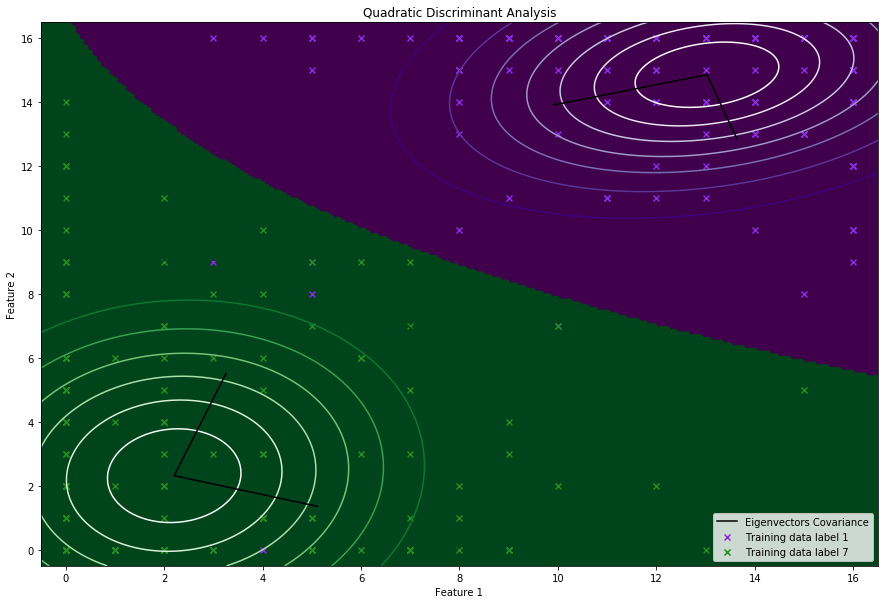

In [14]:
# plotting
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.set_title('Quadratic Discriminant Analysis')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.axis([-0.5,16.5,-0.5,16.5])
# plot of decision areas
ax.scatter(xv, yv, c=prediction, cmap='PRGn')
# plot of training data
plt.scatter(x_features[mask1,0], x_features[mask1,1], marker='x',
            label='Training data label 1', color='blueviolet')
plt.scatter(x_features[mask7,0], x_features[mask7,1], marker='x',
            label='Training data label 7', color='forestgreen')
# calculate and plot 2d-gauss
gauss1 = gaussian.pdf(grid, mean=means[0], cov=cov[0])
gauss7 = gaussian.pdf(grid, mean=means[1], cov=cov[1])
ax.contour(xv, yv, gauss1.reshape(200,200), cmap="Purples_r")
ax.contour(xv, yv, gauss7.reshape(200,200), cmap="Greens_r")

# calculate eigenvectors of covariance matrix and plot them
# centered on corresponding mean, scaled by standard deviation in that direction,
# which is the squareroot of the eigenvalue
eig_values1, eig_vectors1 = np.linalg.eig(cov[0])
ax.plot([means[0,0], means[0,0]-np.sqrt(eig_values1[0])*eig_vectors1[0,0]],
        [means[0,1], means[0,1]-np.sqrt(eig_values1[0])*eig_vectors1[1,0]],
        color='black', label='Eigenvectors Covariance')
ax.plot([means[0,0], means[0,0]-np.sqrt(eig_values1[1])*eig_vectors1[0,1]],
        [means[0,1], means[0,1]-np.sqrt(eig_values1[1])*eig_vectors1[1,1]],
        color='black')

eig_values7, eig_vectors7 = np.linalg.eig(cov[1])
ax.plot([means[1,0], means[1,0]-np.sqrt(eig_values7[0])*eig_vectors7[0,0]],
        [means[1,1], means[1,1]-np.sqrt(eig_values7[0])*eig_vectors7[1,0]],
        color='black')
ax.plot([means[1,0], means[1,0]-np.sqrt(eig_values7[1])*eig_vectors7[0,1]],
        [means[1,1], means[1,1]-np.sqrt(eig_values7[1])*eig_vectors7[1,1]],
        color='black')
ax.legend(loc='lower right');

## 3.4 Performance evaluation

In [15]:
# Calculate performance using 10-fold cross validation
errors_qda = []
errors_train_qda = []
for train, test in kf.split(x_features, y_labels):
    means, cov, priors = fit_qda(x_features[train], y_labels[train])
    # calculate error on test data
    pred_test = predict_qda(means, cov, priors, x_features[test])
    compare_test = pred_test == y_labels[test]
    errors_qda.append(1 - np.sum(compare_test) / len(compare_test))
    
    # calculate error on training data
    pred_train = predict_qda(means, cov, priors, x_features[train])
    compare_train = pred_train == y_labels[train]
    errors_train_qda.append(1 - np.sum(compare_train) / len(compare_train))
    
error_qda = (np.mean(errors_qda), np.std(errors_qda))
error_train_qda = (np.mean(errors_train_qda), np.std(errors_train_qda))
print("QDA mean error rate (10-fold cross validation): " + \
      f"{error_qda[0]:.3f}+-{error_qda[1]:.3f}")
print("QDA training error rate (10-fold cross validation): " + \
      f"{error_train_qda[0]:.3f}+-{error_train_qda[1]:.3f}")

QDA mean error rate (10-fold cross validation): 0.014+-0.014
QDA training error rate (10-fold cross validation): 0.014+-0.002


As we can see here, QDA also has a training error, because outlier have a smaller effect on the training, but because the covariance matrix is also used for classification, the training error is smaller than the training error of the nearest mean classifier.  
The test error is also smaller than with NM, and is the same es the training error, which means the distribution can be well estimated from a training set.

# 4. LDA 
## 4.1 LDA training

In [16]:
def fit_lda(train_features, train_labels, plot_export=False):
    # Mostly the same as QDA, except for covariance
    label_names = np.unique(train_labels)
    F = len(label_names) # number of labels
    D = train_features.shape[1]       # Dimension of features
    N_tot = len(train_features)
    
    means = np.empty((F, D), dtype=float)
    cov = np.empty((D, D), dtype=float)
    priors = np.empty(F, dtype=float)
    
    for i, label in enumerate(label_names):
        mask = train_labels == label
        N = np.sum(mask)
        means[i] = np.mean(train_features[mask], axis=0)
        
        centered_data = train_features[mask] - means[i]
        # adding covariance up as defined in lecture
        cov += np.add.reduce(centered_data[:,:,np.newaxis] * \
                             centered_data[:,np.newaxis,:])
        
        priors[i] = N/N_tot
        
    cov /= N_tot # scaling covariance
    cov_inv = np.linalg.inv(cov)
    # calculating matrix and vector for prediction
    w = 2 * np.dot(means, cov_inv)
    b = - np.diag(np.tensordot(means, np.dot(means, cov_inv), (1, 1))) \
        - np.log(np.linalg.det(cov)) + 2 * np.log(priors)
        
    if plot_export:
        return w, b, means, cov # we need the mean and covariance for plotting
    else:
        return w, b

## 4.2 LDA training

In [17]:
def predict_lda(w, b, test_features, label_names=[1,7]):
    res = np.empty((len(label_names), test_features.shape[0]))
    # calculate cost function for every label
    for k, label in enumerate(label_names):        
        res[k] = np.dot(test_features, w[k]) + b[k]
    
    # maximize cost function, other than in QDA
    label_index = np.argmax(res, axis=0)
    # replace label index with label itself
    return np.fromiter((label_names[i] for i in label_index), dtype='int')

In [18]:
# train with all data for plotting
w, b, means, cov = fit_lda(x_features, y_labels, plot_export=True)

In [19]:
# create grid in feature space
x = np.linspace(-0.5, 16.5, 200)
y = np.linspace(-0.5, 16.5, 200)
xv, yv = np.meshgrid(x, y)
grid = np.column_stack([xv.reshape(40000), yv.reshape(40000)])
# classify grid using LDA
prediction = predict_lda(w, b, grid).reshape(200,200)

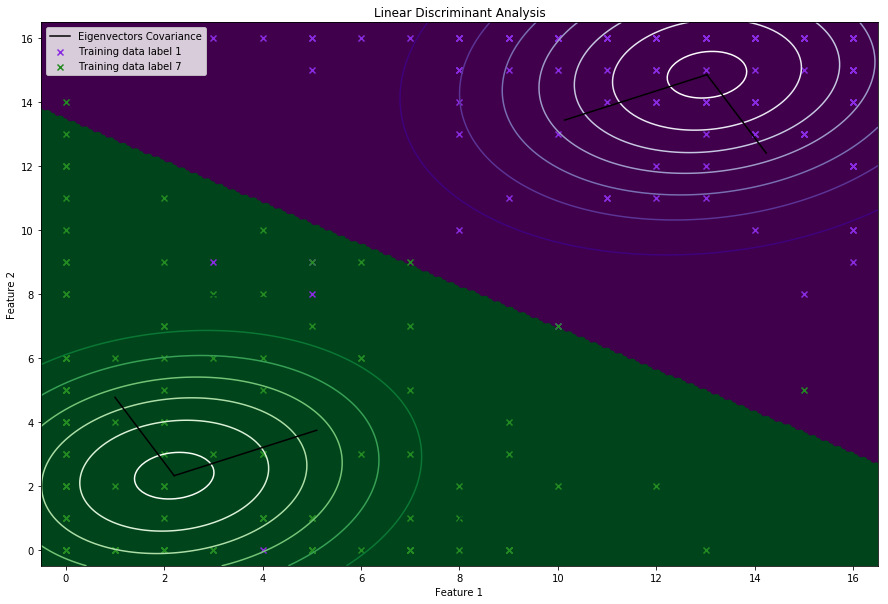

In [20]:
# plotting
fig, ax = plt.subplots(1,1, figsize=(15,10))
ax.set_title('Linear Discriminant Analysis')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.axis([-0.5,16.5,-0.5,16.5])
# plot decision areas
ax.scatter(xv, yv, c=prediction, cmap='PRGn')
# plot training data
plt.scatter(x_features[mask1,0], x_features[mask1,1], marker='x',
            label='Training data label 1', color='blueviolet')
plt.scatter(x_features[mask7,0], x_features[mask7,1], marker='x',
            label='Training data label 7', color='forestgreen')
# plot 2d-gauss
gauss1 = gaussian.pdf(grid, mean=means[0], cov=cov)
gauss7 = gaussian.pdf(grid, mean=means[1], cov=cov)
ax.contour(xv, yv, gauss1.reshape(200,200), cmap="Purples_r")
ax.contour(xv, yv, gauss7.reshape(200,200), cmap="Greens_r")

# calculate and plot eigenvectors of covariance matrix
eig_values, eig_vectors = np.linalg.eig(cov)
ax.plot([means[0,0], means[0,0]-np.sqrt(eig_values[0])*eig_vectors[0,0]],
        [means[0,1], means[0,1]-np.sqrt(eig_values[0])*eig_vectors[1,0]],
        color='black', label='Eigenvectors Covariance')
ax.plot([means[0,0], means[0,0]-np.sqrt(eig_values[1])*eig_vectors[0,1]],
        [means[0,1], means[0,1]-np.sqrt(eig_values[1])*eig_vectors[1,1]],
        color='black')
ax.plot([means[1,0], means[1,0]+np.sqrt(eig_values[0])*eig_vectors[0,0]],
        [means[1,1], means[1,1]+np.sqrt(eig_values[0])*eig_vectors[1,0]],
        color='black')
ax.plot([means[1,0], means[1,0]+np.sqrt(eig_values[1])*eig_vectors[0,1]],
        [means[1,1], means[1,1]+np.sqrt(eig_values[1])*eig_vectors[1,1]],
        color='black')
ax.legend(loc='best');

In [21]:
# Calculate performance using 10-fold cross validation
errors_lda = []
errors_train_lda = []
for train, test in kf.split(x_features, y_labels):
    w, b = fit_lda(x_features[train], y_labels[train])
    # calculate error on test data
    pred_test = predict_lda(w, b, x_features[test])
    compare_test = pred_test == y_labels[test]
    errors_lda.append(1 - np.sum(compare_test) / len(compare_test))
    
    # calculate error on training data
    pred_train = predict_lda(w, b, x_features[train])
    compare_train = pred_train == y_labels[train]
    errors_train_lda.append(1 - np.sum(compare_train) / len(compare_train))
    
error_lda = (np.mean(errors_lda), np.std(errors_lda))
error_train_lda = (np.mean(errors_train_lda), np.std(errors_train_lda))
print("LDA mean error rate (10-fold cross validation): " + \
      f"{error_lda[0]:.3f}+-{error_lda[1]:.3f}")
print("LDA training error rate (10-fold cross validation): " + \
      f"{error_train_lda[0]:.3f}+-{error_train_lda[1]:.3f}")

LDA mean error rate (10-fold cross validation): 0.025+-0.015
LDA training error rate (10-fold cross validation): 0.021+-0.003


With LDA the errror rate is much higher than with QDA, which makes sense because LDA is a simplification of QDA, but it's weird that it is worse than nearest mean, because it uses the covariance for classification, which nearest mean doesn't.  
As in NM and QDA, the training and the test error match up, which shows that the distribution in the training set can model the whole distribution.